In [1]:
import numpy as np
import pandas as pd
from transformers import AutoConfig, Wav2Vec2Processor
from pathlib import Path
from tqdm import tqdm
import os, glob, pickle
import torchaudio
from sklearn.model_selection import train_test_split
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np
import os
import sys
import torch
import torchaudio
import librosa
import IPython.display as ipd
import numpy as np

In [2]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Device name: Tesla P100-PCIE-16GB


In [3]:
from datasets import load_from_disk

In [4]:
train_dataset = load_from_disk('../input/cmu-mosei-small/features/train' )
val_dataset = load_from_disk('../input/cmu-mosei-small/features/val')
test_dataset = load_from_disk('../input/cmu-mosei-small/features/test')

In [5]:
attention_train =[]
input_values_train = []
train_labels = []
ids_train = []
ids_att_train = []
for i in tqdm(range(len(train_dataset))):
    if train_dataset[i]['labels'][5] == 0 and train_dataset[i]['labels'][3] == 0: 
        attention_train.append(torch.tensor(train_dataset[i]['attention_mask']))
        input_values_train.append(torch.tensor(train_dataset[i]['input_values']))
        lis = (train_dataset[i]['labels'])
        lis.pop(5)
        lis.pop(-2)
        train_labels.append(torch.tensor(lis))
        ids_train.append(torch.tensor(train_dataset[i]['ids']))
        ids_att_train.append(torch.tensor(train_dataset[i]['ids_attention']))
    

100%|██████████| 3669/3669 [20:33<00:00,  2.97it/s]


In [6]:
attention_val =[]
input_values_val = []
val_labels = []
ids_val = []
ids_att_val = []
for i in tqdm(range(len(val_dataset))):
    if val_dataset[i]['labels'][5] == 0 and val_dataset[i]['labels'][3] == 0: 
        
        attention_val.append(torch.tensor(val_dataset[i]['attention_mask']))
        input_values_val.append(torch.tensor(val_dataset[i]['input_values']))
        lis = (val_dataset[i]['labels'])
        lis.pop(5)
        lis.pop(-2)
        val_labels.append(torch.tensor(lis))
        ids_val.append(torch.tensor(val_dataset[i]['ids']))
        ids_att_val.append(torch.tensor(val_dataset[i]['ids_attention']))

100%|██████████| 1223/1223 [06:45<00:00,  3.02it/s]


In [7]:
attention_test =[]
input_values_testl = []
test_labels = []
ids_test = []
ids_att_test = []
test_emotions = []
for i in tqdm(range(len(test_dataset))):
    if test_dataset[i]['labels'][5] == 0 and test_dataset[i]['labels'][3] == 0: 
        attention_test.append(torch.tensor(test_dataset[i]['attention_mask']))
        input_values_testl.append(torch.tensor(test_dataset[i]['input_values']))
        lis = (test_dataset[i]['labels'])
        lis.pop(5)
        lis.pop(-2)
        test_labels.append(torch.tensor(lis))
        ids_test.append(torch.tensor(test_dataset[i]['ids']))
        ids_att_test.append(torch.tensor(test_dataset[i]['ids_attention']))

100%|██████████| 1223/1223 [06:53<00:00,  2.96it/s]


In [8]:
#input_values_train = torch.stack(input_values_train)
label_list = [ 'happy', 'sad', 'anger',  'disgust']

In [9]:
disgust_tr = 0
happy_tr = 0
sad_tr = 0
anger_tr = 0
for i in range(len(train_labels)):
    if train_labels[i][0] != 0:
        happy_tr +=1
    if train_labels[i][1] != 0:
        sad_tr +=1
    if train_labels[i][2] != 0:
        anger_tr +=1
    if train_labels[i][3] != 0:
        disgust_tr +=1

In [10]:
disgust_va = 0
happy_va = 0
sad_va = 0
anger_va = 0
for i in range(len(val_labels)):
    if val_labels[i][0] != 0:
        happy_va +=1
    if val_labels[i][1] != 0:
        sad_va +=1
    if val_labels[i][2] != 0:
        anger_va +=1
    if val_labels[i][3] != 0:
        disgust_va +=1

In [11]:
disgust_te = 0
happy_te = 0
sad_te = 0
anger_te = 0
for i in range(len(test_labels)):
    if test_labels[i][0] != 0:
        happy_te +=1
    if test_labels[i][1] != 0:
        sad_te +=1
    if test_labels[i][2] != 0:
        anger_te +=1
    if test_labels[i][3] != 0:
        disgust_te +=1

In [12]:
disgust = disgust_te+ disgust_va+disgust_tr
sad = sad_te+ sad_va+sad_tr
happy = happy_te+ happy_va+happy_tr
anger = anger_te+ anger_va+anger_tr

In [13]:
suma = len(test_labels)+len(val_labels)+len(train_labels)

In [14]:
mean = (happy + sad + anger + disgust)/4
#pos_wieght = torch.tensor([mean/happy, mean/sad, mean/anger,  mean/disgust]).to('cuda')
pos_wieght = torch.tensor([(suma - happy)/happy, (suma - sad)/sad, (suma - anger)/anger,  (suma - disgust)/disgust]).to('cuda')

In [15]:
from tqdm import tqdm
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [16]:
input_values_train = torch.stack(input_values_train)
attention_train = torch.stack(attention_train)
train_labels = torch.stack(train_labels)
ids_train = torch.stack(ids_train)
ids_att_train = torch.stack(ids_att_train)

In [17]:
input_values_val = torch.stack(input_values_val)
attention_val = torch.stack(attention_val)
val_labels = torch.stack(val_labels)
ids_val = torch.stack(ids_val)
ids_att_val = torch.stack(ids_att_val)

In [19]:
input_values_test = torch.stack(input_values_testl)
attention_test = torch.stack(attention_test)
test_labels = torch.stack(test_labels)
ids_test = torch.stack(ids_test)
ids_att_test = torch.stack(ids_att_test)

In [20]:
train = np.zeros(train_labels.shape)
#print('predictions:',predictions, 'labels:', labels, 'probs', probs)
train[np.where(train_labels >= 0.3)] = 1
train_labels = train

val = np.zeros(val_labels.shape)
#print('predictions:',predictions, 'labels:', labels, 'probs', probs)
val[np.where(val_labels >= 0.3)] = 1
val_labels = val

test = np.zeros(test_labels.shape)
#print('predictions:',predictions, 'labels:', labels, 'probs', probs)
test[np.where(test_labels >= 0.3)] = 1
test_labels = test

test_labels = torch.tensor(test_labels)
val_labels = torch.tensor(val_labels)
train_labels = torch.tensor(train_labels)

In [21]:
batch_size = 5

# Create the DataLoader for our training set
train_data = TensorDataset(input_values_train, attention_train, ids_train, ids_att_train, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

# Create the DataLoader for our validation set
val_data = TensorDataset(input_values_val, attention_val, ids_val, ids_att_val, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)

test_data = TensorDataset(input_values_test, attention_test, ids_test, ids_att_test, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [22]:
model_name_or_path = "lighteternal/wav2vec2-large-xlsr-53-greek"
pooling_mode = "mean"

In [23]:
config = AutoConfig.from_pretrained(
    model_name_or_path,
    num_labels=4,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="wav2vec2_clf",
)
setattr(config, 'pooling_mode', pooling_mode)

Downloading:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

/opt/conda/lib/python3.7/site-packages/transformers/configuration_utils.py:359: UserWarning: Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 Transformers. Using `model.gradient_checkpointing_enable()` instead, or if you are using the `Trainer` API, pass `gradient_checkpointing=True` in your `TrainingArguments`.
  "Passing `gradient_checkpointing` to a config initialization is deprecated and will be removed in v5 "


In [24]:
path = 'roberta-base'
config_bert = AutoConfig.from_pretrained(
    path,
    num_labels=4,
    label2id={label: i for i, label in enumerate(label_list)},
    id2label={i: label for i, label in enumerate(label_list)},
    finetuning_task="roberta_clf",
)


Downloading:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [25]:
import torch

In [26]:
%%time
import torch
import torch.nn as nn
from transformers import BertModel
from torch.nn import Conv1d
# Create the BertClassfier class
class WAVClassifier(nn.Module):
    # Bert Model for Classification Tasks.
    def __init__(self, config, config_bert):
        """
        @param    bert: a BertModel object
        @param    classifier: a torch.nn.Module classifier
        @param    freeze_bert (bool): Set `False` to fine-tune the BERT model
        """
        super(WAVClassifier, self).__init__()
        # Specify hidden size of BERT, hidden size of our classifier, and number of labels

        # Instantiate BERT model
        self.wav2vec2  = Wav2Vec2Model.from_pretrained("lighteternal/wav2vec2-large-xlsr-53-greek", config = config)
        self.pooling_mode = config.pooling_mode
        self.classifier_wav = nn.Sequential(
            nn.Dropout(.25),
            nn.Linear(config.hidden_size, config.hidden_size //2),
            #nn.Dropout(0.5),
         #   nn.ReLU(),  
            nn.Dropout(.25),
            nn.Linear(config.hidden_size // 2, config.hidden_size // 4),
            #nn.ReLU()
          #  nn.Linear(config.hidden_size // 4, config.num_labels)
        )
        
        self.roberta = RobertaModel.from_pretrained('roberta-base', config = config_bert)
        self.classifier_text = nn.Sequential(
            nn.Linear(config_bert.hidden_size, config_bert.hidden_size //2),
            #nn.ReLU()
            #nn.Dropout(0.5),
           # nn.Linear(H, D_out)
        )
        
        self.cnn = nn.Sequential(
           # nn.Conv1d(config_bert.hidden_size //2 + config.hidden_size // 4, config_bert.hidden_size //4 + config.hidden_size // 8, kernel_size =5),
            nn.Linear(config_bert.hidden_size //2 + config.hidden_size // 4, config_bert.hidden_size //2 + config.hidden_size // 4) ,
            nn.Dropout(.10),
            nn.Linear(config_bert.hidden_size //2 + config.hidden_size // 4, config.num_labels)
            
        )
      
    def freeze_feature_extractor(self):
        self.wav2vec2.feature_extractor._freeze_parameters()
                
    def merged_strategy(
            self,
            hidden_states,
            mode="mean"
    ):
        if mode == "mean":
            outputs = torch.mean(hidden_states, dim=1)
        elif mode == "sum":
            outputs = torch.sum(hidden_states, dim=1)
        elif mode == "max":
            outputs = torch.max(hidden_states, dim=1)[0]
        else:
            raise Exception(
                "The pooling method hasn't been defined! Your pooling mode must be one of these ['mean', 'sum', 'max']")

        return outputs
        
    def forward(self, input_values, attention_mask, input_ids, attention_ids):
        """
        Feed input to BERT and the classifier to compute logits.
        @param    input_ids (torch.Tensor): an input tensor with shape (batch_size,
                      max_length)
        @param    attention_mask (torch.Tensor): a tensor that hold attention mask
                      information with shape (batch_size, max_length)
        @return   logits (torch.Tensor): an output tensor with shape (batch_size,
                      num_labels)
        """
        # Feed input to BERT
        outputs = self.wav2vec2(
            input_values=input_values,
            attention_mask=attention_mask
        )
        
        # Extract the last hidden state of the token `[CLS]` for classification task
        hidden_states = outputs[0]
        hidden_states = self.merged_strategy(hidden_states, mode=self.pooling_mode)

        # Feed input to classifier to compute logits
        hidden_speech = self.classifier_wav(hidden_states)
        outputs_roberta = self.roberta(
            input_ids=input_ids,
            attention_mask=attention_ids)
        last_hidden_state_cls = outputs_roberta[0][:, 0, :]
        hidden_text = self.classifier_text(last_hidden_state_cls)
        last = torch.cat(([hidden_speech, hidden_text]), dim = 1)
        
        logits = self.cnn(last)
                
       # print(logits.shape)
        return logits

CPU times: user 30.5 ms, sys: 3 µs, total: 30.6 ms
Wall time: 39.2 ms


In [27]:
def initialize_model(epochs=4):
    """Initialize the Bert Classifier, the optimizer and the learning rate scheduler.
    """
    # Instantiate Bert Classifier
    wav_classifier = WAVClassifier(config, config_bert)

    # Tell PyTorch to run the model on GPU
    wav_classifier.to(device)

    # Create the optimizer
    optimizer = AdamW(wav_classifier.parameters(),
                      lr=1e-5,    # Default learning rate
                      eps=1e-8    # Default epsilon value
                      )

    # Total number of training steps
    total_steps = len(train_dataloader) * epochs

    # Set up the learning rate scheduler
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0, # Default value
        num_training_steps=total_steps)
    return wav_classifier, optimizer, scheduler

In [28]:
from sklearn.metrics import accuracy_score

In [29]:


# Specify loss function
loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight = pos_wieght)

def set_seed(seed_value=42):
    """Set seed for reproducibility.
    """
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    torch.cuda.manual_seed_all(seed_value)

def train(model, train_dataloader, val_dataloader=None, epochs=4, evaluation=False):
    """Train the BertClassifier model.
    """
    # Start training loop
    print("Start training...\n")
    train_history = []
    best_valid_loss = float('inf')
    curr_patience = patience = 8
    num_trials = 3
    for epoch_i in range(epochs):
        # =======================================
        #               Training
        # =======================================
        # Print the header of the result table
        print(f"{'Epoch':^7} | {'Batch':^7} | {'Train Loss':^12} | {'Val Loss':^10} | {'Val Acc':^9} | {'Elapsed':^9}")
        print("-"*70)

        # Measure the elapsed time of each epoch
        t0_epoch, t0_batch = time.time(), time.time()

        # Reset tracking variables at the beginning of each epoch
        total_loss, batch_loss, batch_counts = 0, 0, 0

        # Put the model into the training mode
        model.train()

        # For each batch of training data...
        for step, batch in enumerate(train_dataloader):
            batch_counts +=1
            # Load batch to GPU
            b_input_values, b_mask, b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

            # Zero out any previously calculated gradients
            model.zero_grad()

            # Perform a forward pass. This will return logits.
            logits = model(b_input_values, b_mask, b_input_ids, b_attn_mask)

            # Compute loss and accumulate the loss values
            loss = loss_fn(logits, b_labels)
            train_history.append(loss.cpu().detach().numpy())
            batch_loss += loss.item()
            total_loss += loss.item()

            # Perform a backward pass to calculate gradients
            loss.backward()

            # Clip the norm of the gradients to 1.0 to prevent "exploding gradients"
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

            # Update parameters and the learning rate
            optimizer.step()
            scheduler.step()

            # Print the loss values and time elapsed for every 20 batches
            if (step % 20 == 0 and step != 0) or (step == len(train_dataloader) - 1):
                # Calculate time elapsed for 20 batches
                time_elapsed = time.time() - t0_batch

                # Print training results
                print(f"{epoch_i + 1:^7} | {step:^7} | {batch_loss / batch_counts:^12.6f} | {'-':^10} | {'-':^9} | {time_elapsed:^9.2f}")

                # Reset batch tracking variables
                batch_loss, batch_counts = 0, 0
                t0_batch = time.time()

        # Calculate the average loss over the entire training data
        avg_train_loss = total_loss / len(train_dataloader)
        print("-"*70)
        # =======================================
        #               Evaluation
        # =======================================
        if evaluation == True:
            # After the completion of each training epoch, measure the model's performance
            # on our validation set.
            val_loss, val_accuracy, curr_patience, best_valid_loss = evaluate(model, val_dataloader, curr_patience, patience, best_valid_loss)

            # Print performance over the entire training data
            time_elapsed = time.time() - t0_epoch
            
            print(f"{epoch_i + 1:^7} | {'-':^7} | {avg_train_loss:^12.6f} | {val_loss:^10.6f} | {val_accuracy:^9.2f} | {time_elapsed:^9.2f}")
            print("-"*70)
        print("\n")
    
    print("Training complete!")
    return train_history

def evaluate(model, val_dataloader, curr_patience, patience, best_valid_loss, treshold=0.5):
    """After the completion of each training epoch, measure the model's performance
    on our validation set.
    """
    # Put the model into the evaluation mode. The dropout layers are disabled during
    # the test time.
    model.eval()

    # Tracking variables
    val_accuracy = []
    val_loss = []

    # For each batch in our validation set...
    for batch in val_dataloader:
        # Load batch to GPU
        b_input_values, b_mask, b_input_ids, b_attn_mask, b_labels = tuple(t.to(device) for t in batch)

        # Compute logits
        with torch.no_grad():
            logits = model(b_input_values, b_mask, b_input_ids, b_attn_mask)

        # Compute loss
        loss = loss_fn(logits, b_labels)
        val_loss.append(loss.item())

        # Get the predictions
        preds = logits >= treshold

        # Calculate the accuracy rate
      #  print(logits)
       # accuracy = np.mean([(preds[:, i] == b_labels[:, i]).cpu().numpy().mean() for i in range(logits.shape[1])])
        result = multi_label_metrics(logits, b_labels, treshold)
        val_accuracy.append(result['accuracy'])

    # Compute the average accuracy and loss over the validation set.
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    if val_loss <= best_valid_loss:
        best_valid_loss = val_loss
        print("Found new best model on dev set!")
        torch.save(model.state_dict(), 'model.std')
        torch.save(optimizer.state_dict(), 'optim.std')
        curr_patience = patience
        
    else:
        curr_patience -= 1
        if curr_patience <= -1:
            print("Running out of patience, loading previous best model.")
            num_trials -= 1
            curr_patience = patience
            model.load_state_dict(torch.load('model.std'))
            optimizer.load_state_dict(torch.load('optim.std'))
            lr_scheduler.step()
            print(f"Current learning rate: {optimizer.state_dict()['param_groups'][0]['lr']}")

    return val_loss, val_accuracy, curr_patience, best_valid_loss


In [30]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
def multi_label_metrics(predictions, labels, threshold=0.5):
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = torch.nn.Sigmoid()
    #predictions = torch.tensor(predictions)
   # labels = torch.tensor(labels)
  #  predictions = predictions.cpu()
    labels = labels.cpu()
   # print(predictions)
   # predictions = torch.stack(predictions, axis = 1)
    probs = sigmoid(predictions).cpu()
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = np.zeros(probs.shape)
    #print('predictions:',predictions, 'labels:', labels, 'probs', probs)
   # labels = torch.tensor(labels).cpu()
    y_true[np.where(labels >= threshold)] = 1
    y_pred = torch.tensor(y_pred)
   # print(predictions.shape, y_true.shape)
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    metrics = {'f1': f1_micro_average,
               'roc_auc': roc_auc,
               'accuracy': accuracy,
               'prediction':y_pred
              }
    return metrics

In [31]:
import torch
import torch.nn as nn
from torch.nn import BCEWithLogitsLoss, CrossEntropyLoss, MSELoss
from transformers import AutoConfig, Wav2Vec2Processor,Wav2Vec2ForCTC, Wav2Vec2Tokenizer,BertTokenizer
from transformers.models.wav2vec2.modeling_wav2vec2 import (
    Wav2Vec2PreTrainedModel,
    Wav2Vec2Model
)
from transformers.models.roberta.modeling_roberta import (
    RobertaPreTrainedModel,
    RobertaModel
)

In [32]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F
from transformers import BertTokenizer, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [33]:
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', None)
import torch
import random
import time

In [34]:
wav_classifier, optimizer, scheduler = initialize_model(epochs=10)
train_history = train(wav_classifier, train_dataloader, val_dataloader, epochs=10, evaluation=True)

Downloading:   0%|          | 0.00/1.18G [00:00<?, ?B/s]

Some weights of the model checkpoint at lighteternal/wav2vec2-large-xlsr-53-greek were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/478M [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaModel: ['lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.bias', 'lm_head.dense.weight']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
/opt/conda/lib/python3.7/site-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  Futu

Start training...

 Epoch  |  Batch  |  Train Loss  |  Val Loss  |  Val Acc  |  Elapsed 
----------------------------------------------------------------------
   1    |   20    |   0.921643   |     -      |     -     |   22.70  
   1    |   40    |   0.917063   |     -      |     -     |   15.21  
   1    |   60    |   0.882814   |     -      |     -     |   15.67  
   1    |   80    |   0.821034   |     -      |     -     |   15.66  
   1    |   100   |   0.917492   |     -      |     -     |   15.62  
   1    |   120   |   0.877039   |     -      |     -     |   15.56  
   1    |   140   |   0.937329   |     -      |     -     |   15.55  
   1    |   160   |   0.949739   |     -      |     -     |   15.30  
   1    |   180   |   0.939509   |     -      |     -     |   15.58  
   1    |   200   |   0.873272   |     -      |     -     |   15.41  
   1    |   220   |   0.870312   |     -      |     -     |   15.68  
   1    |   240   |   0.921814   |     -      |     -     |   15.37  


In [38]:
def predict(input_values_testl,  attention_test, ids_test, ids_att_test, threshold =0.5):
   # speech = speech_file_to_array_fn(path, sampling_rate)
   # features = processor(speech, sampling_rate=sampling_rate, return_tensors="pt", padding=True)

    #input_values = features.input_values.to(device)
    #attention_mask = features.attention_mask.to(device)
    input_values_testl = torch.tensor(input_values_testl).unsqueeze(0).cuda()
    attention_test = torch.tensor(attention_test).unsqueeze(0).cuda()
    ids_test = torch.tensor(ids_test).unsqueeze(0).cuda()
    ids_att_test = torch.tensor(ids_att_test).unsqueeze(0).cuda()
    #print(input_values.shape)
    with torch.no_grad():
        logits = wav_classifier(input_values_testl, attention_test, ids_test, ids_att_test)
        
    #preds = logits.argmax(axis = 1)
    #accuracy = (preds == labels).cpu().numpy().astype(np.float32)
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(logits).cpu()
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    #print('predictions:',predictions, 'labels:', labels, 'probs', probs)
    y_pred = torch.tensor(y_pred)
   # outputs = [{"Emotion": config.id2label[i], "Score": f"{round(score * 100, 3):.1f}%"} for i, score in enumerate(scores)]
    return y_pred

In [39]:
y_pred = []
for i in tqdm(range(len(test_data))):
    y_pred.append(predict(input_values_testl[i], attention_test[i], ids_test[i], ids_att_test[i]))

  0%|          | 0/1048 [00:00<?, ?it/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  import sys
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if __name__ == "__main__":
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: To copy construct from a tensor, it is recommended to use

In [49]:
pred = torch.stack(y_pred)
pred = pred[:, 0, :]

In [50]:
from sklearn.metrics import classification_report
print(classification_report(test_labels, pred, target_names=label_list))

              precision    recall  f1-score   support

       happy       0.75      0.73      0.74       641
         sad       0.46      0.61      0.52       300
       anger       0.45      0.54      0.49       282
     disgust       0.45      0.50      0.47       232

   micro avg       0.57      0.63      0.60      1455
   macro avg       0.53      0.60      0.56      1455
weighted avg       0.59      0.63      0.61      1455
 samples avg       0.63      0.67      0.62      1455



/opt/conda/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


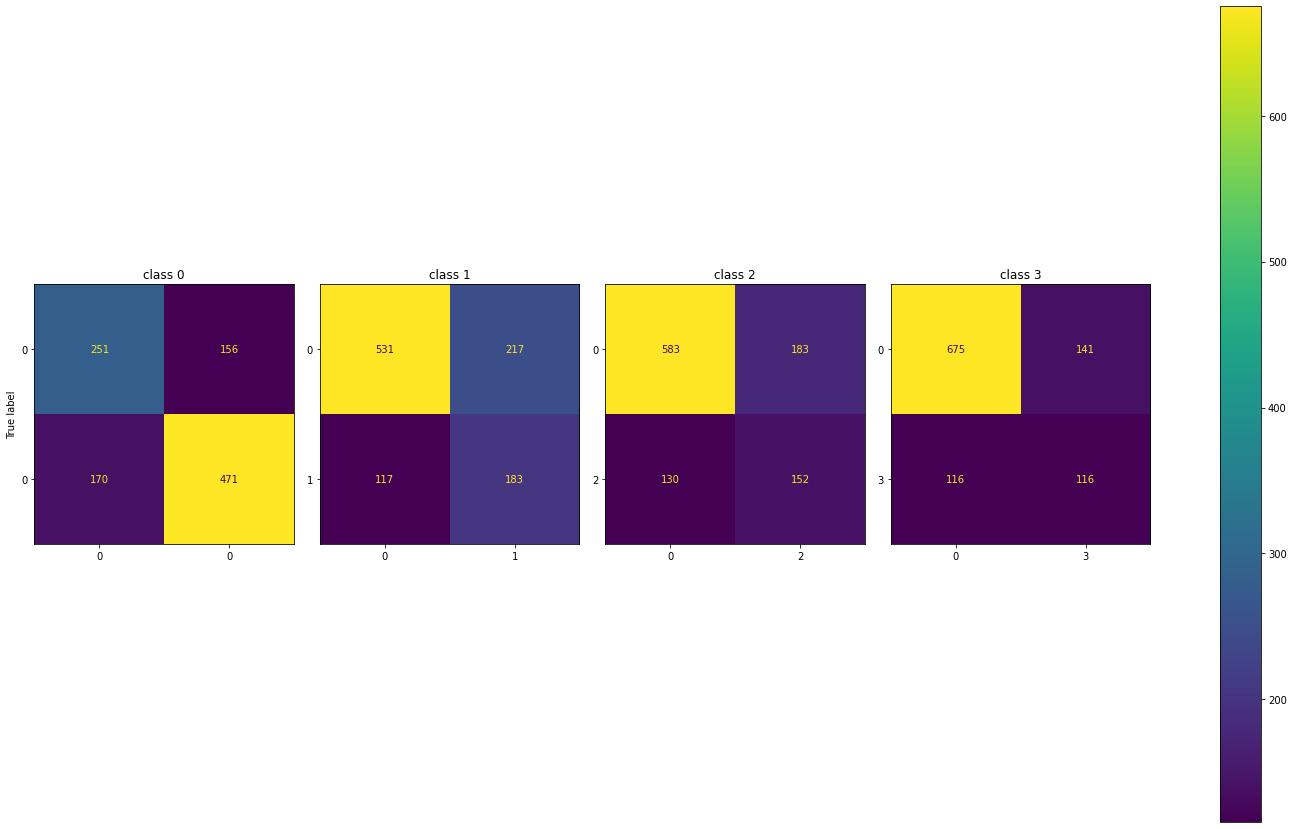

In [51]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_multilabel_classification
from sklearn.tree import DecisionTreeClassifier

f, axes = plt.subplots(1, 4, figsize=(25, 15))
axes = axes.ravel()
for i in range(4):
    disp = ConfusionMatrixDisplay(confusion_matrix(test_labels[:, i],
                                                   pred[:, i]),
                                  display_labels=[0, i])
    disp.plot(ax=axes[i], values_format='.4g')
    disp.ax_.set_title(f'class {i}')
    if i<10:
        disp.ax_.set_xlabel('')
    if i%5!=0:
        disp.ax_.set_ylabel('')
    disp.im_.colorbar.remove()

plt.subplots_adjust(wspace=0.10, hspace=0.1)
f.colorbar(disp.im_, ax=axes)
plt.show()